In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
from cv2 import SIFT_create, cvtColor, COLOR_RGB2GRAY, FlannBasedMatcher, drawMatchesKnn
rgb2gray = lambda img: cvtColor(img, COLOR_RGB2GRAY)
sift = SIFT_create(contrastThreshold=0.02, edgeThreshold=10, nOctaveLayers=3)

%matplotlib widget  

In [2]:
#from project_helpers import *
from project_helpers import get_dataset_info, enforce_essential, compute_epipolar_errors, estimate_F_DLT, count_points_in_front, extract_P_from_E, plot_camera, triangulate_3D_point_DLT

Extracting data

In [3]:
def read_images(img_names):
  images = []
  for name in img_names:
    images.append((plt.imread(name) * 255).astype('uint8'))
  return images

Getting SIFT points and descriptors

In [4]:
def extract_sift_features(images):

  keypoints = []
  descriptors = []
  for image in images:
    kp, des = sift.detectAndCompute(rgb2gray(image), None)
    keypoints.append(kp)
    descriptors.append(des)
  return keypoints, descriptors

In [5]:
def find_good_matches(des1, des2):
  all_matches = FlannBasedMatcher().knnMatch(des1, des2, k=2)
  print('all matches', len(all_matches))
  
  good_matches = []
  for m,n in all_matches:
      if m.distance < 0.75*n.distance:
          good_matches.append([m])
  print('god matches', len(good_matches), '\n ')
  
  return good_matches

Matching sift points and descriptors

In [6]:
def get_2d_points(kp1, kp2, des1, des2, good_matches):
  
  points_1 = []
  points_2 = []
  
  des1_match = []
  des2_match = []
  
  for match in good_matches:
    idx_1 = match[0].queryIdx
    idx_2 = match[0].trainIdx
    
    points_1.append([kp1[idx_1].pt[0], kp1[idx_1].pt[1]])
    des1_match.append(des1[idx_1])
    
    points_2.append([kp2[idx_2].pt[0], kp2[idx_2].pt[1]])
    des2_match.append(des2[idx_2])
  
  x1 = np.array(points_1)
  x2 = np.array(points_2)
  
  x1_homo = np.vstack((x1.T, np.ones(x1.shape[0])))
  x2_homo = np.vstack((x2.T, np.ones(x2.shape[0])))
  
  #print('x1_homo', x1_homo.shape)
  #print('des1_match', len(des1_match))
  
  keypoint_pair = [x1_homo,x2_homo]
  descriptor_pair = [des1_match, des2_match]
    
  return keypoint_pair, descriptor_pair

In [7]:
def get_matching_2D_3D(x, X, good_matches):
  
  x_matched_list = []
  X_matched_list = []
  
  for match in good_matches:
    idx_2D = match[0].queryIdx
    idx_3D = match[0].trainIdx
    
    x_matched_list.append(x[:, idx_2D])
    
    X_matched_list.append(X[:, idx_3D])
  
  x_matched = np.array(x_matched_list).T
  X_matched = np.array(X_matched_list).T
  
  #print('x1_homo', x1_homo.shape)
  #print('des1_match', len(des1_match))
    
  return x_matched, X_matched

Estimating E robustly and extracting P fro E

In [8]:
def estimate_E_and_inliers(x1, x2, des1, des2, eps, seed=None):
    """
    RANSAC estimate of essential matrix using normalized correspondences x1 and x2 and a normalized threshold.
    Note: Make sure to normalize things before using it in this function!
    -------------------------------------------
    x1: Normalized keypoints in image 1 - 3xN np.array or 2xN np.array, as you desire 
    x2: Normalized keypoints in image 2 - 3xN np.array or 2xN np.array, as you desire 
    eps: Normalized inlier threshold - float

    Returns:
    E: 3x3 essential matrix
    inliers: The inlier points
    errs: The epipolar errors
    iters: How many iterations it took
    """
    
    num_points = x1.shape[1]
    num_inliers = 0
    best_num_inliers = 0
    best_inlier_mask = None
    best_errs = None
    iters = 0
    max_iters = 200
    
    
    while iters < max_iters:
        iters += 1
        randind = np.random.choice(num_points, size=8, replace=False)
        E = enforce_essential(estimate_F_DLT(x1[:, randind], x2[:, randind]))
        e1 = compute_epipolar_errors(E, x1, x2)**2 
        e2 = compute_epipolar_errors(E.T, x2, x1)**2
        
        errs = (1/2)*(e1+e2)
        inlier_mask = errs < eps**2
        num_inliers = sum(inlier_mask)

        if num_inliers > best_num_inliers:
            best_num_inliers = num_inliers
            best_errs = errs
            best_inlier_mask = inlier_mask
            ratio_inliers = num_inliers/num_points
            if ratio_inliers > 0.8:
                break
    
    x1_inliers = x1[:, best_inlier_mask]
    x2_inliers = x2[:, best_inlier_mask]
    
    inlier_points = [x1_inliers, x2_inliers]
    
    #print('x1 shape', x1.shape)
    #print('des1 shape', np.array(des1).shape)
    
    des1_inliers = np.array(des1)[best_inlier_mask]
    des2_inliers = np.array(des2)[best_inlier_mask]
            
    E = enforce_essential(estimate_F_DLT(x1_inliers, x2_inliers))
    
    errs = best_errs
    #print('inliers',sum(best_inlier_mask))
    
    return E, inlier_points, des1_inliers, des2_inliers, errs, iters

In [9]:
def get_P(E_robust, keypoint_pair):

  P1_k = np.array([[1, 0, 0, 0],
               [0, 1, 0, 0],
               [0, 0, 1, 0]])
  
  x1, x2 = keypoint_pair
  
  P2_extract = extract_P_from_E(E_robust)
  
  best_i = None
  best_count = 0

  for i in range(4):
    count = count_points_in_front(P1_k, P2_extract[i], x1, x2)
    print('Cam', i, 'inliers', count)
    if count > best_count:
        best_count = count
        best_i = i
        
  print(' ')
  best_P2 = P2_extract[best_i]
  camera_matrix = best_P2
    
  return camera_matrix

In [10]:
# def chain_camera_rotation(R_rel):

#   R0 = np.array([[1, 0, 0],
#               [0, 1, 0],
#               [0, 0, 1]])
#   absolute_rotations = [R0]
  
#   for i in range(len(camera_matrices)-1):
#     R1 = camera_matrices[i+1][:,:3]
#     #print(R1)
#     #print(R0)
#     absolute_rotations.append(R1 @ absolute_rotations[i])
#   print()
#   return R_abs

In [11]:
def estimate_camera_DLT(x, Xmodel):
    if x.shape[0] != 3:
        raise ValueError("x must be of shape 3xN")
    
    if Xmodel.shape[0] != 4:
        raise ValueError("Xmodel must be of shape 4xN")
    
    x_h = x.copy()
    Xmodel_h = Xmodel.copy()
    
    n = x_h.shape[1]
    
    M = np.zeros((2*n, 12), dtype=float)
    
    for i in range(n):
        u = x_h[0, i]
        v = x_h[1, i]
        X = Xmodel_h[:, i]
        
        M[2*i, 0:4] = X
        M[2*i, 8:12] = -u*X
        
        M[2*i+1, 4:8] = X
        M[2*i+1, 8:12] = -v*X
        
    U, S, Vt = np.linalg.svd(M)
    
    v = Vt[-1]
    
    P = v.reshape((3, 4))
    
    P /= P[-1, -1]
    
    
    print(np.linalg.norm(M @ v))
    print(S[-1])
    
    return P


In [12]:
def triangulate_3D_points_DLT_loop(x1_k, x2_k, P1, P2):
  n = x1_k.shape[1]
  X = np.zeros((4,n))
  for i in range(n):
    point_3D = triangulate_3D_point_DLT(x1_k[:, i], x2_k[:, i], P1, P2)
    X[:,i] = point_3D
  
  return X

In [13]:
def estimate_T_DLT(x, X, R):
    n = x.shape[1]
    A = np.zeros((2*n, 3))
    b = np.zeros(2*n)

    for i in range(n):
        Xw = X[:3, i]

        R1 = R[0]
        R2 = R[1]
        R3 = R[2]

        u = x[0, i]
        v = x[1, i]

        A[2*i]   = [1, 0, -u]
        A[2*i+1] = [0, 1, -v]

        b[2*i]   = u * (R3 @ Xw) - (R1 @ Xw)
        b[2*i+1] = v * (R3 @ Xw) - (R2 @ Xw)

    t = np.linalg.lstsq(A, b, rcond=None)[0]
    return t.reshape(3,1)

In [14]:
def compute_reprojection_error(P, X, x):
    
    X_proj = P @ X
    X_proj /= X_proj[2]
    diff = X_proj[:2] - x[:2]
    errs = np.sum(diff**2, axis=0)

    return errs

In [15]:
def estimate_T_robust(x, X, R_abs, eps, seed=None):

    num_points = x.shape[1]
    print('num points', num_points)
    
    num_inliers = 0
    best_num_inliers = 0
    best_inlier_mask = None
    best_errs = None
    iters = 0
    max_iters = 200
    
    while iters < max_iters:
        iters += 1
        randind = np.random.choice(num_points, size=8, replace=False)
        T = estimate_T_DLT(x[:, randind], X[:, randind], R)
        
        P = np.hstack((R_abs, T))
        errs = compute_reprojection_error(P, X, x) 
        inlier_mask = errs < eps
        num_inliers = sum(inlier_mask)

        if num_inliers > best_num_inliers:
            best_num_inliers = num_inliers
            best_errs = errs
            best_inlier_mask = inlier_mask
            ratio_inliers = num_inliers/num_points
            if ratio_inliers > 0.8:
                break
    
            
    best_T = estimate_T_DLT(x[:, best_inlier_mask], X[:, best_inlier_mask], R)
    
    
    #print('inliers',sum(best_inlier_mask))
    
    return best_T

In [16]:
def filter_3d_outliers(Xh, quantile=0.9, scale=5.0):
    """
    Xh: 4xN homogeneous 3D points
    """

    # Convert to Euclidean coordinates
    X = Xh[:3, :] / Xh[3, :]

    # Center of gravity
    X_mean = np.mean(X, axis=1, keepdims=True)

    # Distances to centroid
    dists = np.linalg.norm(X - X_mean, axis=0)

    # Threshold
    thresh = scale * np.quantile(dists, quantile)

    # Inliers
    mask = dists <= thresh

    return Xh[:, mask]

# Step 1 calculate relative orientations

In [17]:
#def run_sfm(dataset_num):

seed = 1

# Get dataset info
K, img_names, init_pair, pixel_threshold = get_dataset_info(4)
init_pair = [4,6]
print('init', init_pair)

eps = 10*pixel_threshold / K[0,0]

# Read images
images = read_images(img_names)

# Extract keypoints and descriptors
keypoints, descriptors = extract_sift_features(images)

# Setting initial matrix
P_0 = np.array([[1, 0, 0, 0],
                [0, 1, 0, 0],
                [0, 0, 1, 0]])

camera_matrices = [P_0]
R_rel = []

keypoints_pair_inlier = []
descriptors_pair_inlier = []

N = len(images)

for i in range(N-1):
  print('Image pair', i)
  
  kp1 = keypoints[i]
  kp2 = keypoints[i+1]
  des1 = descriptors[i]
  des2 = descriptors[i+1]
  
  # Finding good matches
  good_matches = find_good_matches(des1, des2)
  
  # Using sift features and good matches to get keypoints and corresponding descriptors
  keypoints_pair, descriptors_pair_match = get_2d_points(kp1, kp2, des1, des2, good_matches)
  
  x1, x2 = keypoints_pair
  
  xn1 = np.linalg.inv(K) @ x1
  xn2 = np.linalg.inv(K) @ x2
  
  des1_match, des2_match = descriptors_pair_match
  
  #print('len des_1', len(des1_match))
  #print('len des_2', len(des2_match))
  
  E_robust, inliers, des1_inliers, des2_inliers, _, _ = estimate_E_and_inliers(xn1, xn2, des1_match, des2_match, eps, seed = 1)
  
  #print('E', E_robust)
  
  # Calculating camera matrix and corresponding inliers
  P_i = get_P(E_robust, inliers)
  
  # Saving camera matrix, keypoints and their descriptors
  camera_matrices.append(P_i)
  
  R = P_i[:, :3]
  R_rel.append(R)
  
  keypoints_pair_inlier.append(inliers)
  descriptors_pair_inlier.append([des1_inliers, des2_inliers])

#print('R_rel', R_rel)



init [4, 6]
Image pair 0
all matches 29227
god matches 11447 
 
Cam 0 inliers 10640
Cam 1 inliers 3
Cam 2 inliers 0
Cam 3 inliers 0
 
Image pair 1
all matches 27938
god matches 11148 
 
Cam 0 inliers 2
Cam 1 inliers 10924
Cam 2 inliers 0
Cam 3 inliers 0
 
Image pair 2
all matches 26540
god matches 11219 
 
Cam 0 inliers 2
Cam 1 inliers 10994
Cam 2 inliers 0
Cam 3 inliers 0
 
Image pair 3
all matches 26523
god matches 10420 
 
Cam 0 inliers 0
Cam 1 inliers 0
Cam 2 inliers 1
Cam 3 inliers 8439
 
Image pair 4
all matches 26956
god matches 10896 
 
Cam 0 inliers 10626
Cam 1 inliers 6
Cam 2 inliers 0
Cam 3 inliers 0
 
Image pair 5
all matches 28328
god matches 11429 
 
Cam 0 inliers 1
Cam 1 inliers 11193
Cam 2 inliers 0
Cam 3 inliers 0
 
Image pair 6
all matches 28536
god matches 11587 
 
Cam 0 inliers 2
Cam 1 inliers 11335
Cam 2 inliers 0
Cam 3 inliers 0
 
Image pair 7
all matches 31139
god matches 11018 
 
Cam 0 inliers 9131
Cam 1 inliers 7
Cam 2 inliers 0
Cam 3 inliers 0
 
Image pair 8
a

# Step 2 - Upgrade to relative rotations

In [18]:
# R_abs = chain_camera_rotation(R_rel)

R_abs = []
R_abs.append(np.eye(3))

for i in range(1, len(images)):
    R_abs.append(R_rel[i-1] @ R_abs[i-1])

R_abs = np.array(R_abs)

# Step 3 - Reconstructing image points from initial image pair

all matches 26956
god matches 8950 
 
Cam 0 inliers 8674
Cam 1 inliers 9
Cam 2 inliers 0
Cam 3 inliers 0
 


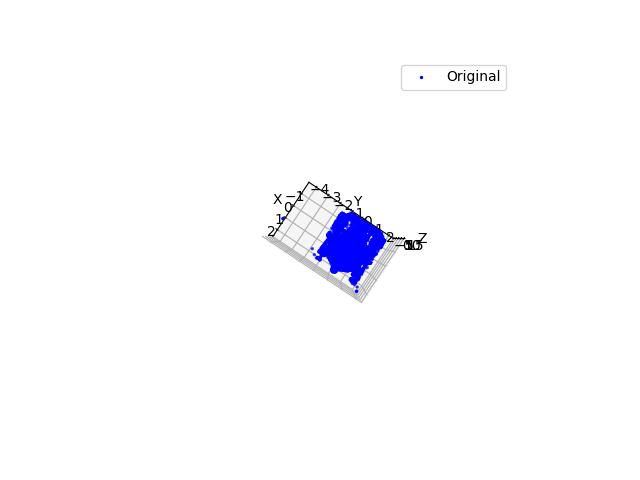

In [19]:
kp1_init = keypoints[init_pair[0]]
kp2_init = keypoints[init_pair[1]]
des1_init = descriptors[init_pair[0]]
des2_init = descriptors[init_pair[1]]

matches_init_pair = find_good_matches(des1_init, des2_init)
points_init_pair, descriptors_init_pair = get_2d_points(kp1_init, kp2_init, des1_init, des2_init, matches_init_pair)

x1, x2 = points_init_pair

xn1 = np.linalg.inv(K) @ x1
xn2 = np.linalg.inv(K) @ x2

des1_match, des2_match = descriptors_init_pair

#print('len des_1', len(des1_match))
#print('len des_2', len(des2_match))

E_robust, inliers, des1_inliers, des2_inliers, _, _ = estimate_E_and_inliers(xn1, xn2, des1_match, des2_match, eps, seed = 1)

P_init_pair = get_P(E_robust, inliers)

X_init = triangulate_3D_points_DLT_loop(inliers[0], inliers[1], P_0, P_init_pair)
X_init_filtered = filter_3d_outliers(X_init)
# X_world = np.linalg.inv(abs_rotation[init_pair[0]]) @ X_init[:3]
# X_world = np.vstack((X_world, np.ones(X_init.shape[1])))

des_abs = des1_inliers

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X_init_filtered[0, :], X_init_filtered[1, :], X_init_filtered[2, :], s=2, c='b', label='Original')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend()
ax.view_init(90, 35)
# ax.set_xlim(-0.5, 0.5)
# ax.set_ylim(-0.5, 0.5)
# ax.set_zlim(0.5, 1.5)
#ax.set_zlim(0, 6)
ax.set_aspect('equal')

plot_camera(P_0,1,ax)
plot_camera(P_init_pair,1,ax)

plt.show()

# Step 4 - Robustly calculating camera center/translation for each image

all matches 10643
god matches 2588 
 
xi (3, 2588)
Xi (4, 2588)
num points 2588
all matches 10926
god matches 3263 
 
xi (3, 3263)
Xi (4, 3263)
num points 3263
all matches 10996
god matches 3718 
 
xi (3, 3718)
Xi (4, 3718)
num points 3718
all matches 8440
god matches 4251 
 
xi (3, 4251)
Xi (4, 4251)
num points 4251
all matches 10632
god matches 5551 
 
xi (3, 5551)
Xi (4, 5551)
num points 5551
all matches 11194
god matches 5401 
 
xi (3, 5401)
Xi (4, 5401)
num points 5401
all matches 11337
god matches 4503 
 
xi (3, 4503)
Xi (4, 4503)
num points 4503
all matches 9138
god matches 2488 
 
xi (3, 2488)
Xi (4, 2488)
num points 2488
all matches 10853
god matches 2162 
 
xi (3, 2162)
Xi (4, 2162)
num points 2162
all matches 11639
god matches 1795 
 
xi (3, 1795)
Xi (4, 1795)
num points 1795
all matches 11527
god matches 1454 
 
xi (3, 1454)
Xi (4, 1454)
num points 1454
all matches 10469
god matches 1148 
 
xi (3, 1148)
Xi (4, 1148)
num points 1148
all matches 9096
god matches 909 
 
xi (3,

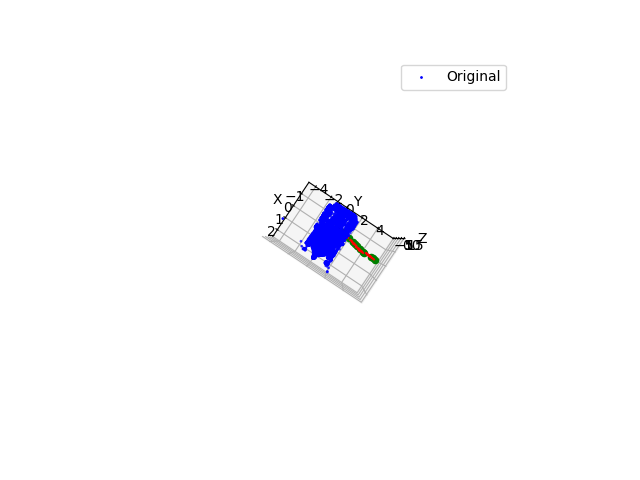

In [20]:
P_abs = [P_0]

for i in range(N - 1):
  kp_i = keypoints_pair_inlier[i][1]
  des_i = descriptors_pair_inlier[i][1]
  
  good_matches = find_good_matches(des_i, des_abs)
  
  x_i_matched, X_init_matched = get_matching_2D_3D(kp_i, X_init, good_matches)
  
  #des1_match, des2_match = descriptors_pair_match
  
  #print('len des_abs', len(des_abs))
  #print('len des_i', len(des_i))
  
  #E_robust, inliers, des1_inliers, des2_inliers, _, _ = estimate_E_and_inliers(keypoints_pair[0], keypoints_pair[1], des1_match, des2_match, eps)
  
  #P_i = get_P(E_robust, inliers)
  
  #print('x_0', x1_k_inliers.shape)
  #print('x2_k_inliers', x2_k_inliers.shape)
  
  #X = triangulate_3D_points_DLT_loop(inliers[0], inliers[1], P_0, P_i)
  
  print('xi', x_i_matched.shape)
  print('Xi', X_init_matched.shape)
  
  R = R_abs[i+1]
  eps = 0.00007
  
  #print(len(x_i_matched))
  #print(len(X_init_matched))
  
  T = estimate_T_robust(x_i_matched, X_init_matched, R, eps)
  P = np.hstack((R, T))
  P_abs.append(P)

#print(cam_mat_abs)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X_init_filtered[0, :], X_init_filtered[1, :], X_init_filtered[2, :], s=1, c='b', label='Original')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend()
ax.view_init(90, 35)
# ax.set_xlim(-0.5, 0.5)
# ax.set_ylim(-0.5, 0.5)
# ax.set_zlim(0.5, 1.5)
#ax.set_zlim(0, 6)
ax.set_aspect('equal')


print(len(P_abs))
for P in P_abs:
  plot_camera(P,1,ax)

plt.show()

#run_sfm(2)

# Step 6 - Triangulating points for all pairs

Cam pair 0 1
all matches 9096
god matches 904 
 


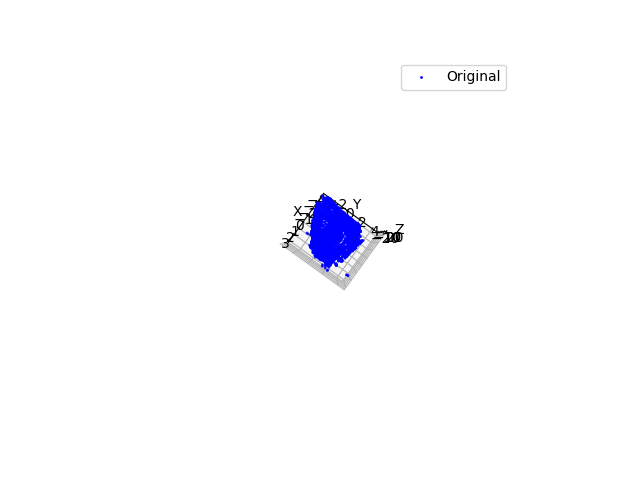

Cam pair 1 2
all matches 9096
god matches 912 
 


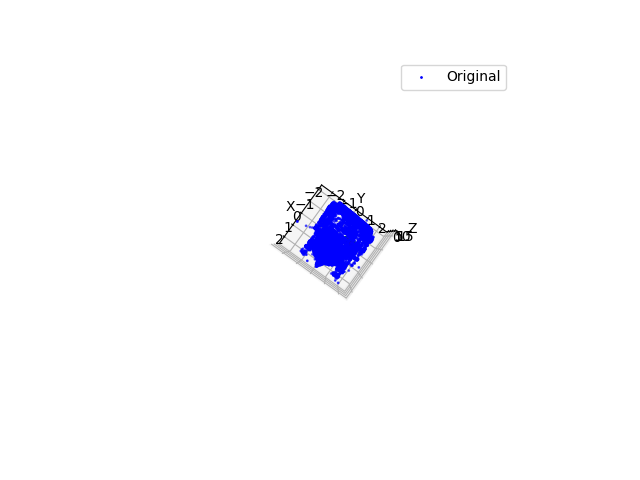

Cam pair 2 3
all matches 9096
god matches 902 
 


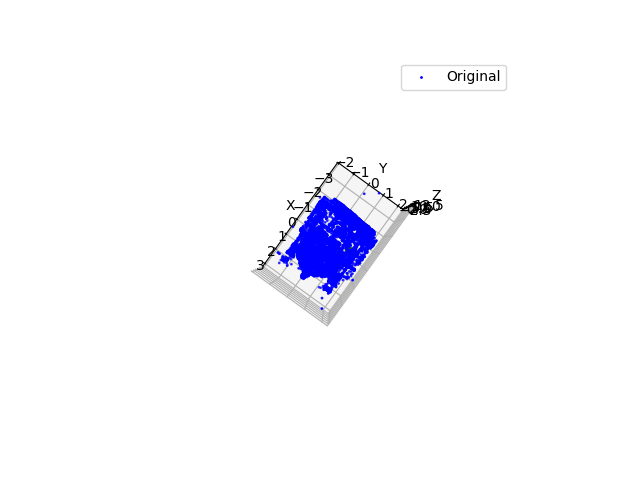

Cam pair 3 4
all matches 9096
god matches 905 
 


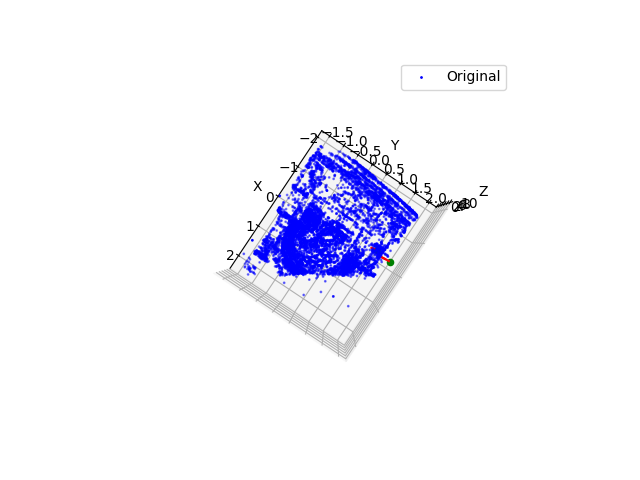

Cam pair 4 5
all matches 9096
god matches 905 
 


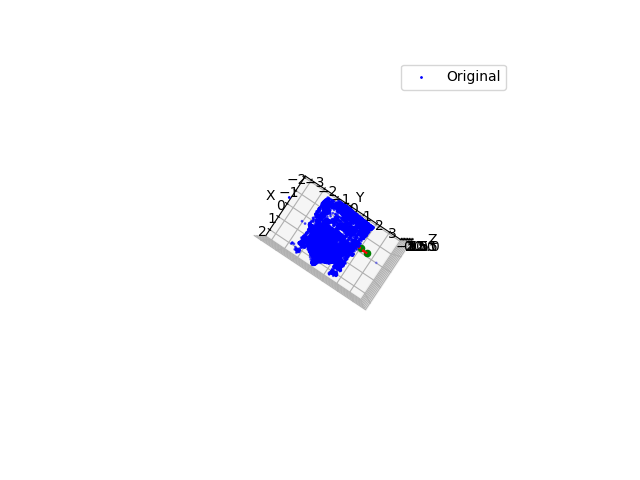

Cam pair 5 6
all matches 9096
god matches 898 
 


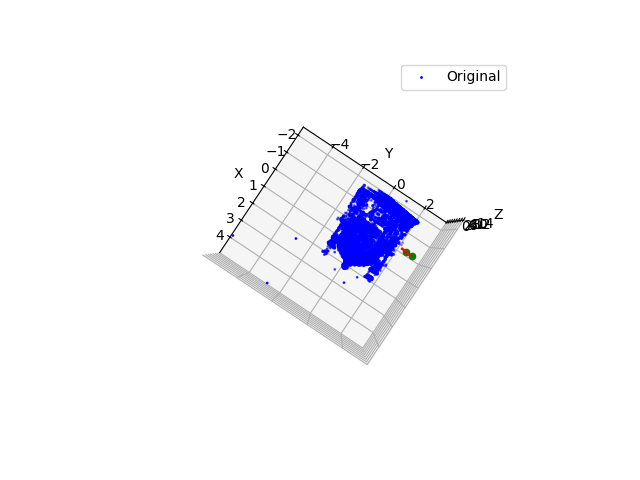

Cam pair 6 7
all matches 9096
god matches 904 
 


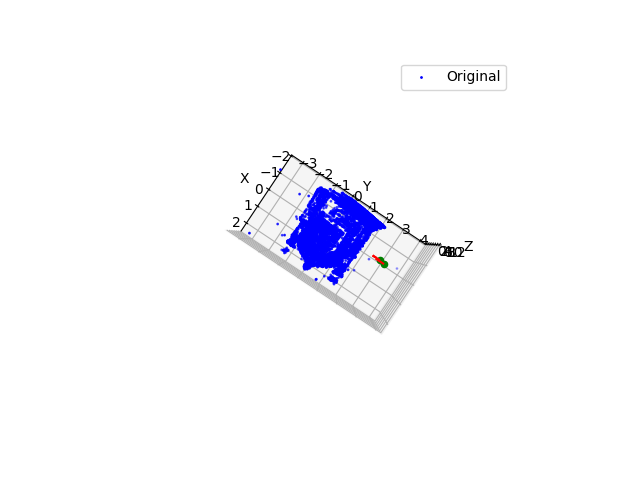

Cam pair 7 8
all matches 9096
god matches 898 
 


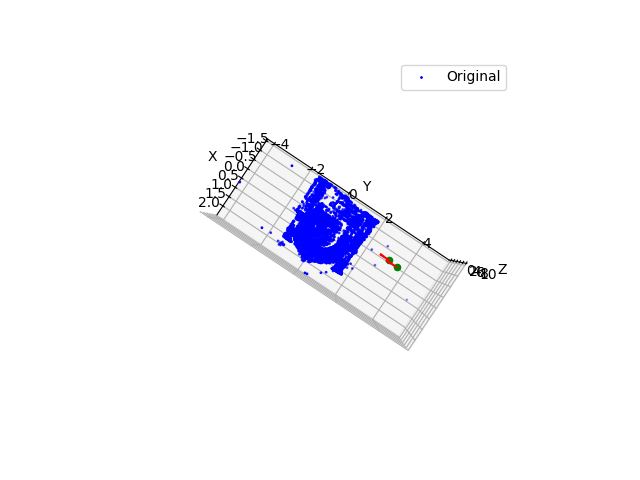

Cam pair 8 9
all matches 9096
god matches 896 
 


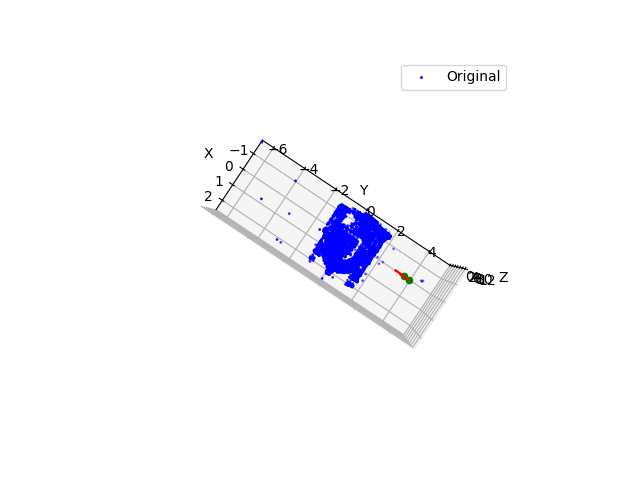

Cam pair 9 10
all matches 9096
god matches 892 
 


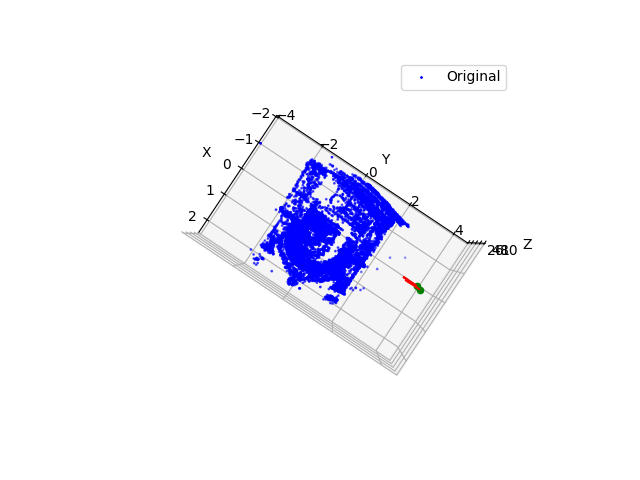

Cam pair 10 11
all matches 9096
god matches 906 
 


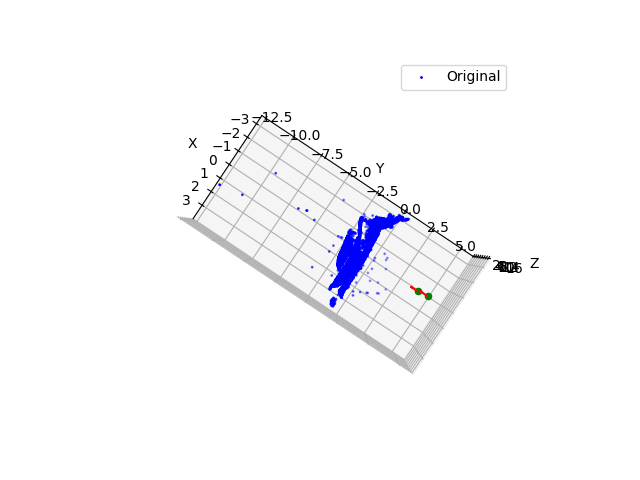

Cam pair 11 12
all matches 9096
god matches 907 
 


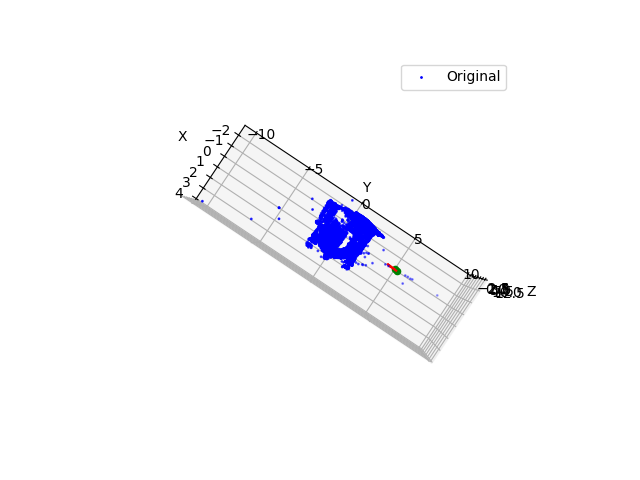

Cam pair 12 13
all matches 9096
god matches 903 
 


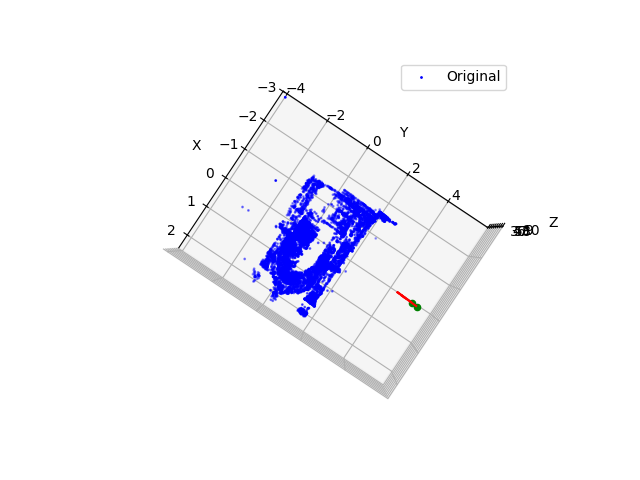

In [21]:
for i in range(N - 1):
  P1 = P_abs[i]
  P2 = P_abs[i+1]
  
  print('Cam pair', i, i+1)
  
  x1 = keypoints_pair_inlier[i][0]
  x2 = keypoints_pair_inlier[i][1]
  
  good_matches = find_good_matches(des_i, des_abs)
  
  x_i_matched, X_init_matched = get_matching_2D_3D(kp_i, X_init, good_matches)
  
  X = triangulate_3D_points_DLT_loop(x1, x2, P1, P2)
  X_filtered = filter_3d_outliers(X)
  fig = plt.figure()
  ax = fig.add_subplot(111, projection='3d')

  ax.scatter(X_filtered[0, :], X_filtered[1, :], X_filtered[2, :], s=1, c='b', label='Original')

  ax.set_xlabel('X')
  ax.set_ylabel('Y')
  ax.set_zlabel('Z')
  ax.legend()
  ax.view_init(90, 35)
  ax.set_aspect('equal')

  plot_camera(P1,1,ax)
  plot_camera(P2,1,ax)

  plt.show()

In [22]:
# def pflat(x):
#     y = x / x[-1,:]
#     return y

# for i in range(len(images)-1):
#     x1_proj = pflat(cam_mat_abs[i] @ X_world)

#     x1_proj = K @ x1_proj

#     plt.figure()
#     img = images[i]
#     plt.imshow(img, cmap='gray')
#     plt.axis('equal')
#     #plt.scatter(x1[0], x1[1], s=2)
#     plt.scatter(x1_proj[0], x1_proj[1], s=3)
#     plt.show()